In [85]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,random_split
import pickle



In [86]:
device = torch.device('cuda') # torch.device('cpu')
device

device(type='cuda')

In [87]:
with open('train.pkl', 'rb') as file:
    train_data = pickle.load(file)

with open('test_no_target.pkl', 'rb') as file:
    test_no_target_data = pickle.load(file)

In [88]:
classes_dict = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}

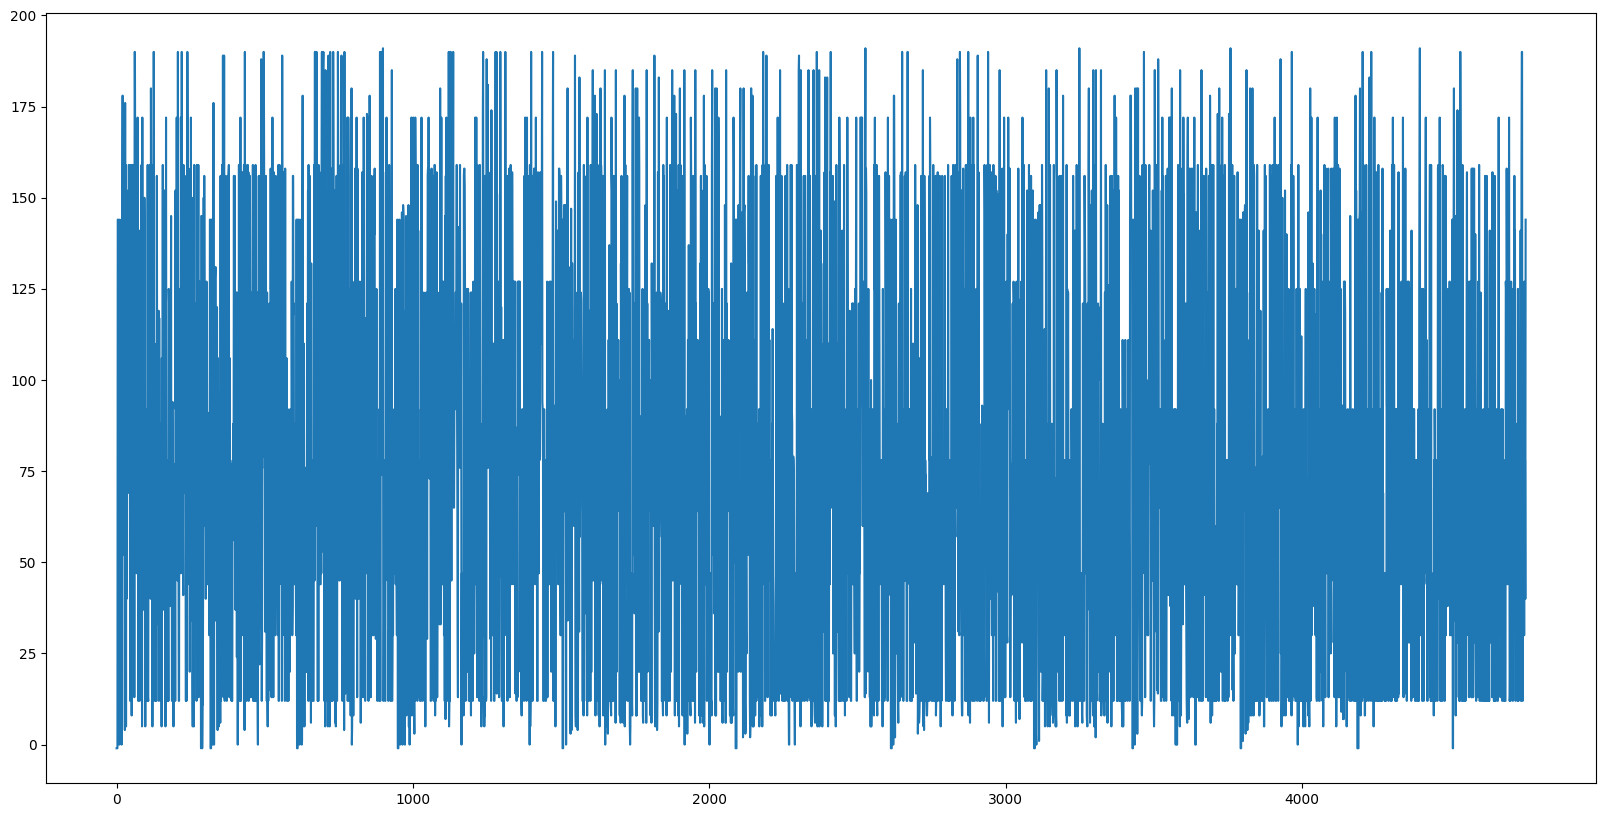

In [89]:
plt.figure(figsize=[20, 10])
plt.plot(train_data[0][0])
plt.show()

In [90]:
min_val = 1000000
max_val = -1000000
max_len = 0
for x in train_data:
    if min(x[0]) < min_val:
        min_val = min(x[0])
    if max(x[0]) > max_val:
        max_val = max(x[0])
    if len(x[0]) > max_len:
        max_len = len(x[0])
samples = len(train_data)

print(min_val, max_val, max_len, samples)

-1.0 191.0 6308 2939


In [91]:
from torch.utils.data import random_split
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size

train_dataset, test_dataset = random_split(train_data, [train_size, test_size])

In [167]:
train_classes = []
train_data = []

test_classes = []
test_data = []

for x in train_dataset:
    train_data.append(torch.from_numpy((x[0]- min_val) / max_val).float())
    train_classes.append(x[1])

for x in test_dataset:
    test_data.append(torch.from_numpy((x[0]- min_val) / max_val).float())
    test_classes.append(x[1])

train_classes = np.array(train_classes)
train_data_targets = torch.from_numpy(train_classes).long()

test_classes = np.array(test_classes)
test_data_targets = torch.from_numpy(test_classes).long()

classes, counts = torch.unique(test_data_targets, return_counts=True)
# classes, counts = torch.unique(train_data_targets, return_counts=True)

# Wyświetlenie wyników
for cls, count in zip(classes, counts):
    print(f"Klasa {cls}: {count} wystąpień")


Klasa 0: 332 wystąpień
Klasa 1: 87 wystąpień
Klasa 2: 37 wystąpień
Klasa 3: 86 wystąpień
Klasa 4: 46 wystąpień


In [93]:
from torch.utils.data import Dataset

class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [94]:


train_set = VariableLenDataset(train_data, train_data_targets)
test_set = VariableLenDataset(test_data, test_data_targets)

In [151]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 200


def pad_collate(batch, pad_value=200):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]

    xx_pad = pad_sequence([torch.tensor(x) for x in xx], batch_first=True, padding_value=pad_value)
    yy = torch.tensor(yy) 

    return xx_pad, yy, x_lens


In [152]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=lambda x: pad_collate(x))
test_loader = DataLoader(test_set, batch_size=32, drop_last=False, collate_fn=pad_collate)

next(iter(train_loader))

/tmp/ipykernel_344927/2874882105.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx_pad = pad_sequence([torch.tensor(x) for x in xx], batch_first=True, padding_value=pad_value)


(tensor([[7.5916e-01, 3.6649e-01, 4.8691e-01,  ..., 2.0000e+02, 2.0000e+02,
          2.0000e+02],
         [6.0209e-01, 4.7120e-02, 2.1466e-01,  ..., 2.0000e+02, 2.0000e+02,
          2.0000e+02],
         [1.7801e-01, 8.3246e-01, 2.5131e-01,  ..., 2.0000e+02, 2.0000e+02,
          2.0000e+02],
         ...,
         [5.2356e-03, 3.8743e-01, 3.8743e-01,  ..., 2.0000e+02, 2.0000e+02,
          2.0000e+02],
         [5.9162e-01, 5.9162e-01, 5.9162e-01,  ..., 2.0000e+02, 2.0000e+02,
          2.0000e+02],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.0000e+02, 2.0000e+02,
          2.0000e+02]]),
 tensor([0, 3, 0, 0, 0, 1, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 2, 1,
         0, 0, 3, 1, 2, 0, 2, 0]),
 [208,
  152,
  83,
  96,
  78,
  48,
  52,
  183,
  228,
  623,
  1782,
  1401,
  88,
  774,
  1149,
  36,
  976,
  52,
  440,
  40,
  111,
  1479,
  326,
  156,
  129,
  192,
  210,
  51,
  117,
  1086,
  282,
  68])

In [162]:


class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional=False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                            bidirectional=bidirectional, dropout=0.4, batch_first=True)
        self.fc = nn.Linear(hidden_size * self.bidirectional, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers * self.bidirectional, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers * self.bidirectional, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, lengths, hidden):
        x_packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.lstm(x_packed, hidden)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        lengths = torch.tensor(lengths, device=x.device)  
        # We use the last output for classification
        if self.bidirectional == 1:
            out = output[torch.arange(output.size(0)), lengths - 1]
        else:
            out = torch.cat((output[torch.arange(output.size(0)), lengths - 1, :self.hidden_size],
                             output[torch.arange(output.size(0)), 0, self.hidden_size:]), dim=1)
        
        x = self.fc(out)
        return x, hidden

model = LSTMRegressor(1, 5, 2, 5).to(device)


In [163]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
class_weights = torch.tensor([0.05, 0.16, 0.5, 0.17, 0.3], device=device)  # przykładowe wagi dla klas 0, 1, 2, 3, 4
loss_fun = nn.CrossEntropyLoss(weight=class_weights)
# Training loop
for epoch in range(101):
    for x, targets, lengths in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        
        preds, _ = model(x, lengths, (hidden, state))
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3f}")


/tmp/ipykernel_344927/2874882105.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx_pad = pad_sequence([torch.tensor(x) for x in xx], batch_first=True, padding_value=pad_value)


Epoch: 0, loss: 1.673
Epoch: 10, loss: 1.443
Epoch: 20, loss: 1.567
Epoch: 30, loss: 1.617
Epoch: 40, loss: 1.651
Epoch: 50, loss: 1.544
Epoch: 60, loss: 1.334
Epoch: 70, loss: 1.543
Epoch: 80, loss: 1.421
Epoch: 90, loss: 1.631
Epoch: 100, loss: 1.472


In [164]:
model.eval()
total_loss = 0
correct = 0
with torch.no_grad():
    for x, targets, lengths in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        
        preds, _ = model(x, lengths, (hidden, state))
        loss = loss_fun(preds, targets)
        total_loss += loss.item()
        pred_classes = preds.argmax(dim=1)
        correct += (pred_classes == targets).sum().item()
        if not((pred_classes == 0).sum().item() and (pred_classes == 3).sum().item()):
            print(pred_classes)

accuracy = correct / len(train_loader.dataset)
average_loss = total_loss / len(train_loader)


print(f'Validation Loss: {average_loss:.3f}, Validation Accuracy: {accuracy:.3f}')


/tmp/ipykernel_344927/2874882105.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx_pad = pad_sequence([torch.tensor(x) for x in xx], batch_first=True, padding_value=pad_value)


Validation Loss: 1.495, Validation Accuracy: 0.320


In [166]:
model.eval()
total_loss = 0
correct = 0
with torch.no_grad():
    for x, targets, lengths in test_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        
        preds, _ = model(x, lengths, (hidden, state))
        loss = loss_fun(preds, targets)
        total_loss += loss.item()
        pred_classes = preds.argmax(dim=1)
        correct += (pred_classes == targets).sum().item()
        print(pred_classes)
        print(targets)


accuracy = correct / len(test_loader.dataset)
average_loss = total_loss / len(test_loader)


print(f'Validation Loss: {average_loss:.3f}, Validation Accuracy: {accuracy:.3f}')

/tmp/ipykernel_344927/2874882105.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx_pad = pad_sequence([torch.tensor(x) for x in xx], batch_first=True, padding_value=pad_value)


tensor([4, 3, 4, 3, 4, 3, 1, 3, 4, 0, 4, 3, 2, 4, 4, 1, 3, 4, 0, 0, 0, 4, 0, 3,
        1, 4, 3, 3, 0, 2, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 1, 0, 0, 0, 0, 1, 4, 0, 0, 1, 0, 4,
        0, 3, 4, 0, 0, 1, 0, 1], device='cuda:0')
tensor([1, 1, 3, 0, 3, 3, 4, 2, 3, 0, 3, 3, 1, 3, 0, 3, 2, 3, 0, 3, 2, 0, 4, 0,
        0, 1, 1, 3, 4, 3, 4, 2], device='cuda:0')
tensor([0, 0, 3, 3, 0, 1, 3, 1, 0, 1, 3, 0, 1, 3, 0, 0, 0, 4, 3, 4, 0, 2, 0, 1,
        0, 1, 2, 0, 0, 3, 2, 0], device='cuda:0')
tensor([3, 3, 4, 4, 4, 0, 3, 0, 4, 2, 3, 0, 3, 0, 0, 1, 0, 3, 4, 3, 0, 3, 4, 3,
        4, 3, 1, 3, 4, 4, 3, 1], device='cuda:0')
tensor([3, 4, 1, 3, 2, 0, 3, 0, 0, 1, 1, 3, 4, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2,
        3, 0, 0, 0, 0, 3, 3, 1], device='cuda:0')
tensor([3, 3, 2, 3, 0, 4, 4, 0, 4, 4, 3, 1, 4, 2, 4, 4, 4, 4, 0, 0, 3, 2, 4, 4,
        0, 4, 4, 3, 0, 4, 4, 3], device='cuda:0')
tensor([3, 1, 2, 3, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0,

In [169]:
counts = torch.tensor([332, 87, 37, 86, 46], dtype=torch.float)

# Obliczanie wag
weights = 1.0 / counts
weights = weights / weights.sum()
weights = weights.to(device)
weights

tensor([0.0402, 0.1535, 0.3608, 0.1552, 0.2902], device='cuda:0')